# Google Earth Engine (GEE) and Image Analysis

This tutorial explains how to use the module ***climada.util.earth_engine***. It queries data from the Google Earth Engine Python API (https://earthengine.google.com/).  A few basic methods of image processing will also be presented using algorythms from Scikit-image (https://scikit-image.org/). A lot of complementary information can be found on this page https://developers.google.com/earth-engine/ (concerns mostly the GEE Java API, but concept and methods are well detailed). GEE is a multi-petabyte catalog of satellite imagery and geospatial datasets. The data are also available on the website of providers, GEE is just more user-friendly as all datasets are available through the same platform. 


## Connect to Google Earth Engine API
To access the data, you have to create an account on https://signup.earthengine.google.com/#!/, this step might take some time. Then, install and connect your Python to the API using the terminal. Be sure that climada_env is activated.

In Terminal or Anaconda prompt

<span style="color:blue"> $ source activate climada_env</span> 

<span style="color:blue">$ conda install -c conda-forge earthengine-api</span> 

Then, when the installation is finished, type

<span style="color:blue">$ earthengine authenticate</span>

This will open a web page where you have to enter your account information and a code is provided. Paste it in the terminal. 

Then, check in Python if it has worked with the lines below. Import also webbrowser for further steps.

In [2]:
import webbrowser

import ee
ee.Initialize()
image = ee.Image('srtm90_v4')
print(image.getInfo())

{'type': 'Image', 'bands': [{'id': 'elevation', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -32768, 'max': 32767}, 'dimensions': [432000, 144000], 'crs': 'EPSG:4326', 'crs_transform': [0.000833333333333, 0.0, -180.0, 0.0, -0.000833333333333, 60.0]}], 'version': 1494271934303000, 'id': 'srtm90_v4', 'properties': {'system:time_start': 950227200000, 'system:time_end': 951177600000, 'system:asset_size': 18827626666}}


## Obtain images
The module ***climada.util.earth_engine*** enables to select images from some collections of GEE and download them as Geotiff data.

In GEE, you can either access directly one **image** or a **collection**. All products available are detailed on this page https://developers.google.com/earth-engine/datasets/.  

In [3]:
# Access a specific image
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318'); #Landsat 8 image, with Top of Atmosphere processing, on 2014/03/18 

# Access a collection
collection = 'LANDSAT/LE07/C01/T1' #Landsat 7 raw images collection

If you have a collection, specification of the time range and area of interest. Then, use methods of the serie **obtain_image_type(collection,time_range,area)** depending the type of product needed.
#### Time range
It depends on the image acquisition period of the targeted satellite and type of images desired (without clouds, from a specific period...) 

#### Area
GEE needs a special format for defining an area of interest. It has to be a GeoJSON Polygon and the coordinates should be first defined in a list and then converted using ee.Geometry. It is possible to use data obtained via Exposure layer. Some examples are given below.

In [36]:
#Landsat_composite in Dresden area
area_dresden = list([(13.6, 50.96), (13.9, 50.96), (13.9, 51.12), (13.6, 51.12), (13.6, 50.96)])
area_dresden = ee.Geometry.Polygon(area_dresden) 
time_range_dresden = ['2002-07-28', '2002-08-05']

collection_dresden = ('LANDSAT/LE07/C01/T1')
print(type(area_dresden))

#Population density in Switzerland
list_swiss = list([(6.72, 47.88),(6.72, 46.55),(9.72, 46.55),(9.72, 47.88),(6.72, 47.88)])        
area_swiss = ee.Geometry.Polygon(list_swiss)                  
time_range_swiss=['2002-01-01', '2005-12-30']

collection_swiss = ee.ImageCollection('CIESIN/GPWv4/population-density')
print(type(collection_swiss))

#Sentinel 2 cloud-free image in Zürich
collection_zurich = ('COPERNICUS/S2')
list_zurich = list([(8.53, 47.355),(8.55, 47.355),(8.55, 47.376),(8.53, 47.376),(8.53, 47.355)])        
area_zurich = ee.Geometry.Polygon(list_swiss) 
time_range_zurich = ['2018-05-01', '2018-07-30']


#Landcover in Europe with CORINE dataset
dataset_landcover = ee.Image('COPERNICUS/CORINE/V18_5_1/100m/2012')
landCover_layer = dataset_landcover.select('landcover')
print(type(landCover_layer))

<class 'ee.geometry.Geometry'>
<class 'ee.imagecollection.ImageCollection'>
<class 'ee.image.Image'>


In [37]:
#Methods from climada.util.earth_engine module
def obtain_image_landsat_composite(collection, time_range, area):
    """ Selection of Landsat cloud-free composites in the Earth Engine library
    See also: https://developers.google.com/earth-engine/landsat

    Parameters:
        collection (): name of the collection
        time_range (['YYYY-MT-DY','YYYY-MT-DY']): must be inside the available data
        area (ee.geometry.Geometry): area of interest

    Returns:
        image_composite (ee.image.Image)
     """
    collection = ee.ImageCollection(collection)

    ## Filter by time range and location
    collection_time = collection.filterDate(time_range[0], time_range[1])
    image_area = collection_time.filterBounds(area)
    image_composite = ee.Algorithms.Landsat.simpleComposite(image_area, 75, 3)
    return image_composite

def obtain_image_median(collection, time_range, area):
    """ Selection of median from a collection of images in the Earth Engine library
    See also: https://developers.google.com/earth-engine/reducers_image_collection

    Parameters:
        collection (): name of the collection
        time_range (['YYYY-MT-DY','YYYY-MT-DY']): must be inside the available data
        area (ee.geometry.Geometry): area of interest

    Returns:
        image_median (ee.image.Image)
     """
    collection = ee.ImageCollection(collection)

    ## Filter by time range and location
    collection_time = collection.filterDate(time_range[0], time_range[1])
    image_area = collection_time.filterBounds(area)
    image_median = image_area.median()
    return image_median

def obtain_image_sentinel(collection, time_range, area):
    """ Selection of median, cloud-free image from a collection of images in the Sentinel 2 dataset
    See also: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

    Parameters:
        collection (): name of the collection
        time_range (['YYYY-MT-DY','YYYY-MT-DY']): must be inside the available data
        area (ee.geometry.Geometry): area of interest

    Returns:
        sentinel_median (ee.image.Image)
     """
#First, method to remove cloud from the image
    def maskclouds(image):
        band_qa = image.select('QA60')
        cloud_mask = ee.Number(2).pow(10).int()
        cirrus_mask = ee.Number(2).pow(11).int()
        mask = band_qa.bitwiseAnd(cloud_mask).eq(0) and(
            band_qa.bitwiseAnd(cirrus_mask).eq(0))
        return image.updateMask(mask).divide(10000)

    sentinel_filtered = (ee.ImageCollection(collection).
                         filterBounds(area).
                         filterDate(time_range[0], time_range[1]).
                         filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).
                         map(maskclouds))

    sentinel_median = sentinel_filtered.median()
    return sentinel_median


In [38]:
#Application to examples
composite_dresden = obtain_image_landsat_composite(collection_dresden, time_range_dresden, area_dresden)
median_swiss = obtain_image_median(collection_swiss, time_range_swiss, area_swiss)
zurich_median = obtain_image_sentinel(collection_zurich, time_range_zurich, area_zurich)

#Selection of specific bands from an image
zurich_band = zurich_median.select(['B4','B3','B2']) 


print(composite_dresden.getInfo())
print(type(median_swiss))
print(type(zurich_band))

{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:4326', 'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:4326', 'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:4326', 'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:4326', 'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:4326', 'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]}, {'id': 'B6_VCID_1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:4326', 'crs_transform': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},

## Download images

To visualize and work on images, it is easier to download them (in Geotiff), using the **get_url(name, image, scale, region)** method. The image will be downloaded regarding a region and a scale. 'region' is obtained from the area, but the format has to be adjusted using **get_region(geom)** method.

In [39]:
def get_region(geom):
    """Get the region of a given geometry, needed for exporting tasks.

    Parameters:
        geom (ee.Geometry, ee.Feature, ee.Image): region of interest

    Returns:
        region (list)
    """
    if isinstance(geom, ee.Geometry):
        region = geom.getInfo()["coordinates"]
    elif isinstance(geom, ee.Feature, ee.Image):
        region = geom.geometry().getInfo()["coordinates"]
    elif isinstance(geom, list):
        condition = all([isinstance(item) == list for item in geom])
        if condition:
            region = geom
    return region


region_dresden = get_region(area_dresden)
region_swiss = get_region(area_swiss)
region_zurich= get_region(area_zurich)

In [41]:
def get_url(name, image, scale, region):
    """It will open and download automatically a zip folder containing Geotiff data of 'image'.
    If additional parameters are needed, see also:
    https://github.com/google/earthengine-api/blob/master/python/ee/image.py

    Parameters:
        name (str): name of the created folder
        image (ee.image.Image): image to export
        scale (int): resolution of export in meters (e.g: 30 for Landsat)
        region (list): region of interest

    Returns:
        path (str)
     """
    path = image.getDownloadURL({
        'name':(name),
        'scale': scale,
        'region':(region)
        })

    webbrowser.open_new_tab(path)
    return path

    
 
url_swiss = get_url('swiss_pop', median_swiss, 900, region_swiss)
url_dresden = get_url('dresden', composite_dresden, 30, region_dresden)
url_landcover = get_url('landcover_swiss', landCover_layer, 100, region_swiss)

#For the example of Zürich, due to size, it doesn't work on Jupyter Notebook but it works on Python
#url_zurich = get_url('sentinel', zurich_band, 10, region_zurich)

print(url_swiss)
print(url_dresden)
print(url_landcover)

https://earthengine.googleapis.com/api/download?docid=6b6d96f567d6a055188c8c17dd24bcb8&token=00a796601efe425c821777a284bff361
https://earthengine.googleapis.com/api/download?docid=15182f82ba65ce24f62305e4465ac21c&token=5da59a20bb84d79bcf7ce958855fe848
https://earthengine.googleapis.com/api/download?docid=07c14e22d96a33fc72a7ba16c2178a6a&token=0cfa0cd6537257e96600d10647375ff4


## Image Visualization and Processing

In this section, basics methods of image processing will be presented as well as tools to visualize the image. The images downloaded before are used as examples but these methods works with all tif data. Scikit-image (https://scikit-image.org/) needs to be imported.

First, bands can be combined, for example to obtain an RGB image from the Red, Blue and Green bands. It is done with gdal_merge.py (see: https://gdal.org/programs/gdal_merge.html). It is better if bands are named just as B1, B2, B3 ... in the folder containing the image data.

In Terminal or Anaconda prompt (be sure that climada_env is activated):

<span style="color:blue"> $ cd '/your/path/to/image_downloaded_folder'

<span style="color:blue"> $ gdal_merge.py -separate -co PHOTOMETRIC=RGB -o merged.tif B_red.tif B_blue.tif B_green.tif

The RGB image will be merged.tif

In [6]:
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

from skimage.io import imread
from skimage import exposure
from skimage.filters import try_all_threshold
from skimage.filters import threshold_otsu, threshold_local
from skimage import measure
from skimage import feature


In [7]:
import os
from climada.util import DATA_DIR

swiss_pop = os.path.join(DATA_DIR, 'demo/earth_engine', 'population-density_median.tif')
dresden = os.path.join (DATA_DIR, 'demo/earth_engine', 'dresden.tif') #B4 of Dresden example
landcover = os.path.join (DATA_DIR, 'demo/earth_engine', 'landcover.tif')
rgb_zurich = os.path.join (DATA_DIR, 'demo/earth_engine', 'rgb_zurich.tif') #created using gdal_merge.py



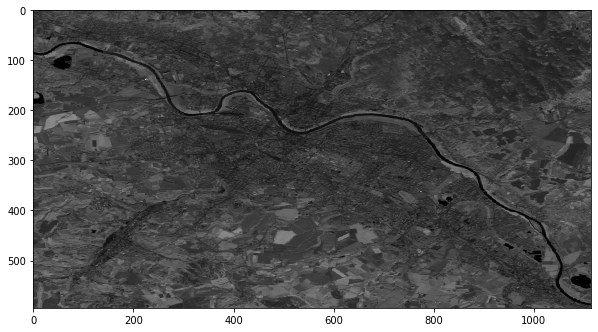

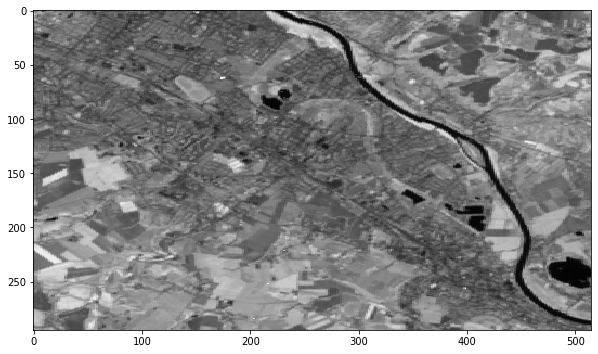

In [9]:
#Read a tif in python and Visualize the image
image_dresden = imread(dresden)
plt.figure(figsize=(10, 10))
plt.imshow(image_dresden, cmap='gray', interpolation='nearest')
plt.axis()
plt.show()

#Crop the image
image_dresden_crop=image_dresden[300:700,600:1400]
plt.figure(figsize=(10, 10))
plt.imshow(image_dresden_crop, cmap='gray', interpolation='nearest')
plt.axis()
plt.show()



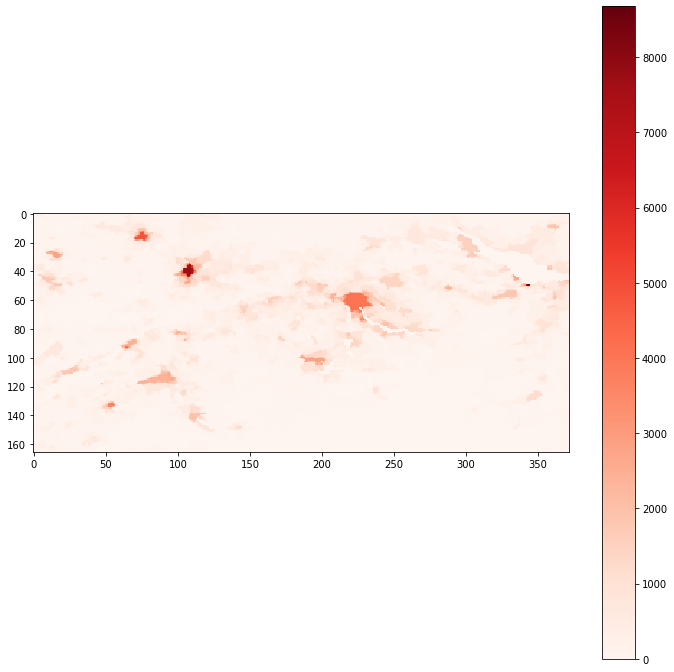

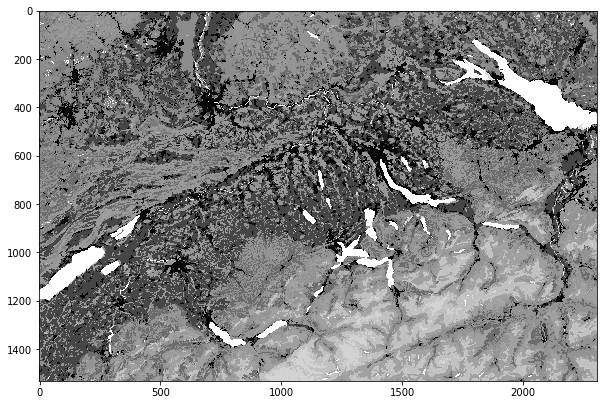

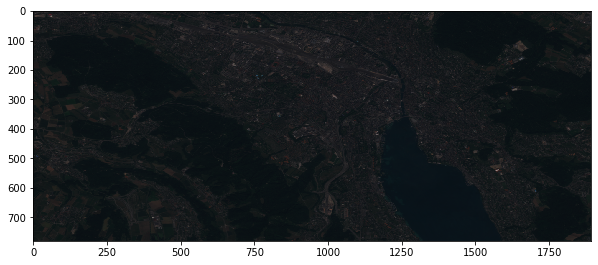

In [10]:
image_pop= imread(swiss_pop)
plt.figure(figsize=(12, 12))
plt.imshow(image_pop, cmap='Reds', interpolation='nearest')
plt.colorbar()
plt.axis()
plt.show()

image_landcover= imread(landcover)
plt.figure(figsize=(10, 10))
plt.imshow(image_landcover, cmap='gray', interpolation='nearest')
plt.axis()
plt.show()

image_rgb= imread(rgb_zurich)
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb, interpolation='nearest')
plt.axis()
plt.show()



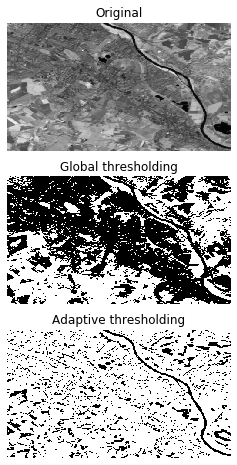

64832


In [11]:
#Thresholding: Selection of pixels with regards with their value

global_thresh = threshold_otsu(image_dresden_crop)
binary_global = image_dresden_crop > global_thresh

block_size = 35
adaptive_thresh = threshold_local(image_dresden_crop, block_size, offset=10)
binary_adaptive = image_dresden_crop > adaptive_thresh

fig, axes = plt.subplots(nrows=3, figsize=(7, 8))
ax = axes.ravel()
plt.gray()

ax[0].imshow(image_dresden_crop)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_adaptive)
ax[2].set_title('Adaptive thresholding')

for a in ax:
    a.axis('off')
plt.show()

print(np.sum(binary_global))
